# Analysis of monthly return data

## Description

- Calculate mean return per Style

In [98]:
import feather
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

In [2]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AffinityPropagation

from sklearn.preprocessing import Normalizer, MaxAbsScaler

# Setup

In [393]:
# Convert to date format
begin_date = '2018-01-01' 
end_date = '2019-01-01'

## Load Data

### Returns

In [394]:
path = '../data/processed/EDY/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

# Convert to date format and filter based on date
returns['date'] =  pd.to_datetime(returns['caldt'], format='%Y-%m-%d')
returns = returns[returns['date'] > begin_date]

### Summary

In [395]:
path = '../data/processed/EDY/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(15391, 13)

In [396]:
# Convert to date format and filter based on date with mask that is also used on holdings
summary['date'] =  pd.to_datetime(summary['report_dt'], format='%Y-%m-%d')
date_mask = summary['date'] > begin_date
summary = summary[date_mask]
summary.shape

(4244, 14)

In [417]:
summary

,level_0,index,port_no,report_dt,index_fund_flag,et_flag,lipper_class,mutual_fund,sample,cap_class,style_class,crsp_portno,fund_no,date
10,159,1823,1000052,2018-01-31,MF,MF,LCVE,Y,Y,L,V,1000052.0,31002.0,2018-01-31
11,160,1824,1000052,2018-02-28,MF,MF,LCVE,Y,Y,L,V,1000052.0,31002.0,2018-02-28
12,161,1825,1000052,2018-03-31,MF,MF,LCVE,Y,Y,L,V,1000052.0,31002.0,2018-03-31
13,162,1826,1000052,2018-04-30,MF,MF,LCVE,Y,Y,L,V,1000052.0,31002.0,2018-04-30
14,163,1827,1000052,2018-05-31,MF,MF,LCVE,Y,Y,L,V,1000052.0,31002.0,2018-05-31
60,444,3463,1000103,2018-01-31,MF,MF,LCVE,Y,Y,L,V,1000103.0,22018.0,2018-01-31
61,445,3464,1000103,2018-02-28,MF,MF,LCVE,Y,Y,L,V,1000103.0,22018.0,2018-02-28
62,446,3465,1000103,2018-03-31,MF,MF,LCVE,Y,Y,L,V,1000103.0,22018.0,2018-03-31
63,447,3466,1000103,2018-04-30,MF,MF,LCVE,Y,Y,L,V,1000103.0,22018.0,2018-04-30
64,448,3467,1000103,2018-05-31,MF,MF,LCVE,Y,Y,L,V,1000103.0,22018.0,2018-05-31


### Holdings

In [397]:
path = '../data/processed/EDY/holdings_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(15391, 8995)

In [398]:
holdings = holdings[date_mask.values]

In [399]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(4244, 14)
Shape of holding information
(4244, 8995)


### portno_map

In [400]:
path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

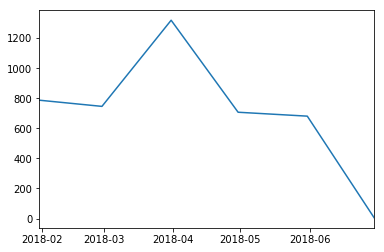

In [401]:
summary['report_dt'].value_counts().plot()

## Merge Crsp_Obj_Cd onto returns data

### Merge does not take dates into account -> TODO

In [402]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged.shape

(136092, 18)

In [403]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(48251, 18)

In [404]:
returns_merged.sample()

,crsp_fundno,caldt,mret,date_x,level_0,index,port_no,report_dt,index_fund_flag,et_flag,lipper_class,mutual_fund,sample,cap_class,style_class,crsp_portno,fund_no,date_y
31634,16705.0,2018-01-31,0.069579,2018-01-31,17289.0,214885,1022067.0,2018-03-31,MF,MF,LCCE,Y,Y,L,C,1022067.0,16705.0,2018-03-31


#### Take only needed columns and reorder them

In [405]:
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','style_class','cap_class']]

In [406]:
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,style_class,cap_class
607,2018-05-31,3023.0,1025916.0,0.048017,SCCE,C,S


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [407]:
group_by = 'style_class'

In [408]:
obj_codes = returns_merged[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values

In [409]:
returns_merged.sample(1)

,caldt,fund_no,port_no,mret,lipper_class,style_class,cap_class
38941,2018-01-31,20126.0,1022323.0,0.065773,LCVE,V,L


In [410]:
# Analysis of selected funds
returns_obj = returns_merged.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [411]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [412]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [413]:
returns_obj_n = returns_obj.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns=group_by)

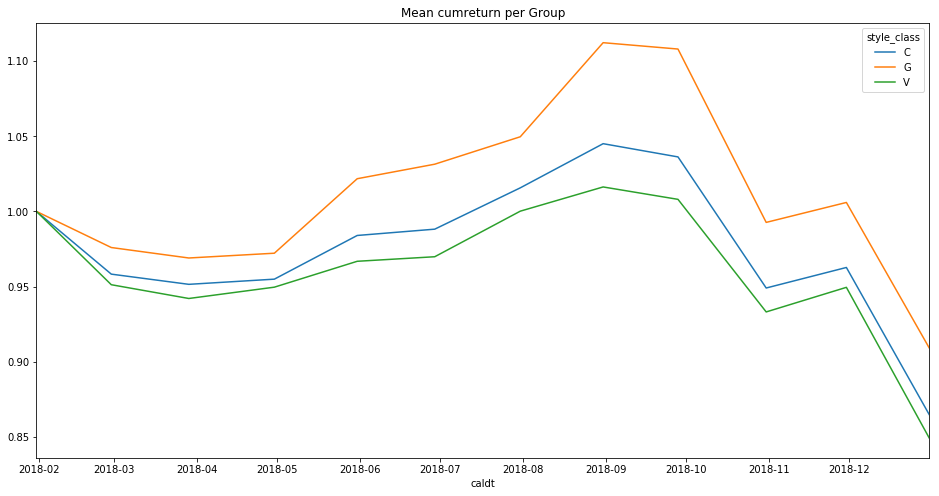

In [414]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [355]:
transformer = MaxAbsScaler().fit(holdings) # fit does nothing.
transformer

MaxAbsScaler(copy=True)

In [356]:
holdings = transformer.transform(holdings)

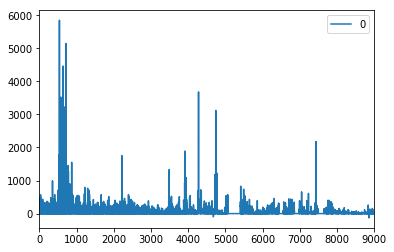

In [415]:
pd.DataFrame(holdings.sum(0)).T.plot()

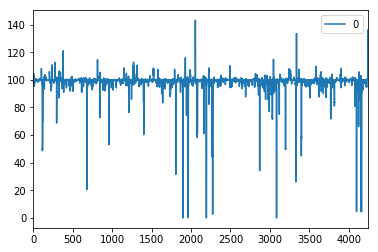

In [416]:
pd.DataFrame(holdings.sum(1)).plot()

In [366]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 3,
                verbose = True,
                n_init = 10, # Number of runs
                n_jobs= -1,
                random_state=0).fit(holdings)

Start kMeans...


In [367]:
lables = pd.DataFrame(kmeans.labels_)

In [368]:
summary['cluster'] = lables.values

In [369]:
pd.crosstab(summary['cap_class'],summary['cluster'])

cluster,0,1,2
cap_class,,,
L,0,66,1897
M,55,779,4
S,464,978,1


In [370]:
pd.crosstab(summary['style_class'],summary['cluster'])

cluster,0,1,2
style_class,,,
C,18,1068,750
G,501,374,703
V,0,381,449


## Chart the returns of the formed clustes

In [373]:
summary.sample()

,level_0,index,port_no,report_dt,index_fund_flag,et_flag,lipper_class,mutual_fund,sample,cap_class,style_class,crsp_portno,fund_no,date,cluster
11136,83524,473482,1026985,2018-03-31,MF,MF,MCGE,Y,Y,M,G,1026985.0,27061.0,2018-03-31,1


#### Merge new clusters into returns

In [374]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
10489,2018-07-31,7903.0,1021100.0,0.008539,SCGE,0.0


#### Calc mean return per Obj_cd

In [375]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([1., 2., 0.])

In [376]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [377]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

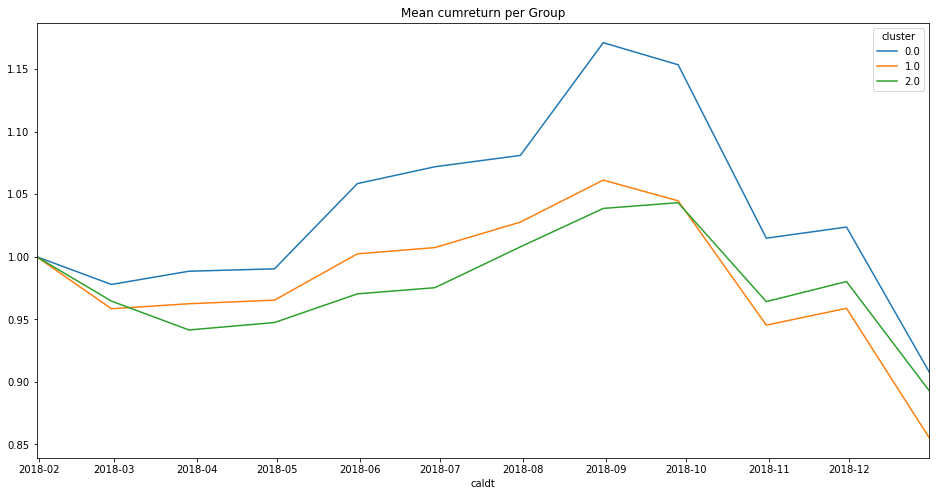

In [379]:
returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

# Samples per Fund -> weights per fund

In [380]:
index = pd.DataFrame(np.arange(summary.shape[0]))

In [381]:
index = index.groupby(summary['port_no']).tail(20)

In [382]:
index = index.values.T.flatten()

In [383]:
summary = summary.loc[index,:]
holdings = holdings[index]
holdings.shape

/Users/alexandersteeb/.virtualenvs/mf/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(523, 8995)

#### Sonstiges

In [384]:
result_mat = pd.DataFrame({'Clusters': clusters, 'Inertia':results})

NameError: name 'clusters' is not defined

In [385]:
plt.plot(result_mat['Clusters'],result_mat['Inertia'])

NameError: name 'result_mat' is not defined

# Visualize

In [30]:
MiniBatchKMeans?

For n_clusters = 4 The average silhouette_score is : -0.23710713370442554


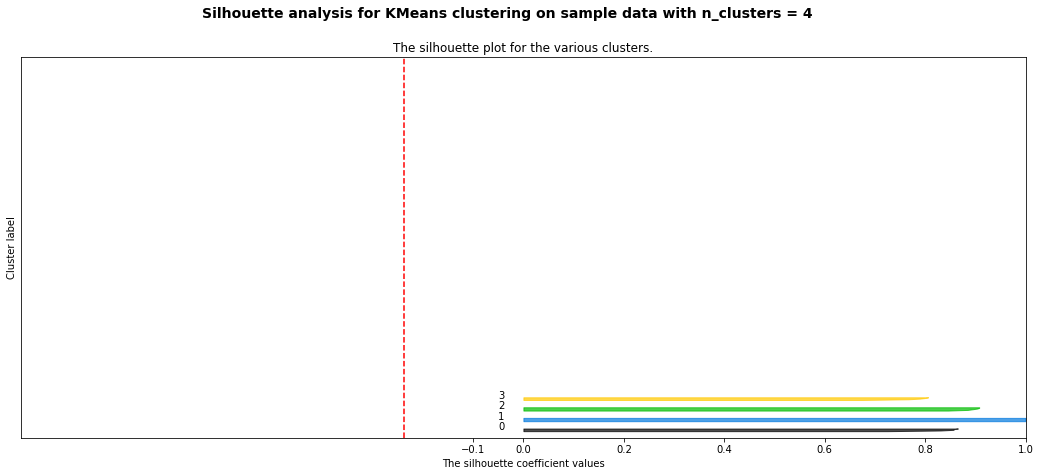

CPU times: user 619 ms, sys: 65 ms, total: 684 ms
Wall time: 353 ms


In [387]:
%%time
#holdings = holdings[:3000]
X = holdings
n_clusters = [4]

clusters = []
results = []



for n_clusters in n_clusters:
    clusterer = DBSCAN(
                        eps=0.5, 
                        min_samples=5, 
                        metric='euclidean', 
                        metric_params=None, 
                        leaf_size=50, 
                        p=None, 
                        n_jobs=-1)
    
    
    cluster_fit = clusterer.fit(holdings)
#    clusters.append(n_clusters)
#    results.append(cluster_fit.inertia_)    
    
    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.45324387254279286
For n_clusters = 4 The average silhouette_score is : 0.1339350792131928
For n_clusters = 6 The average silhouette_score is : -0.00015566591712760412
For n_clusters = 8 The average silhouette_score is : 0.01568091207784738
For n_clusters = 10 The average silhouette_score is : 0.014853795085998068


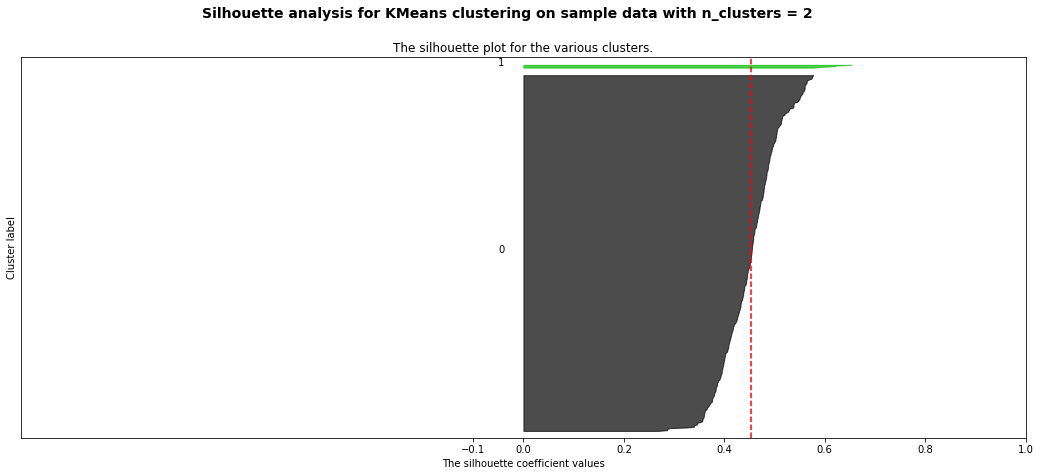

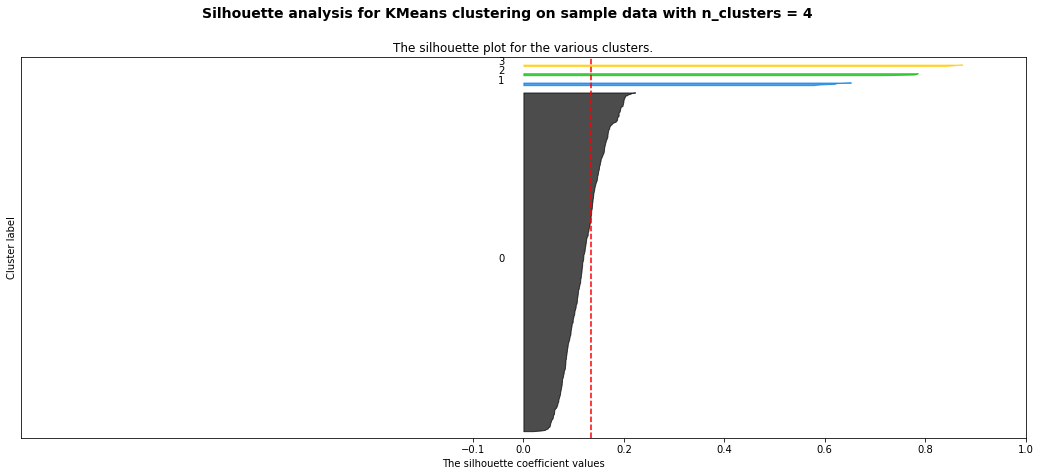

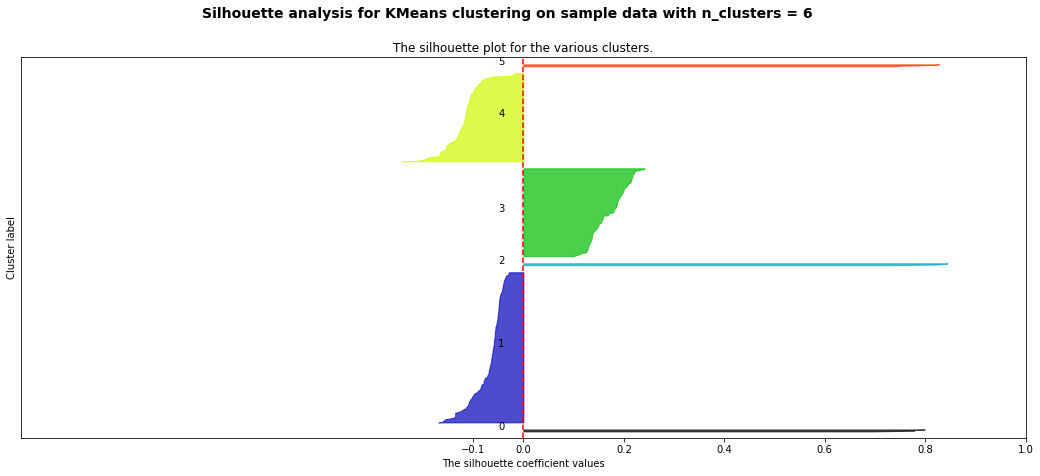

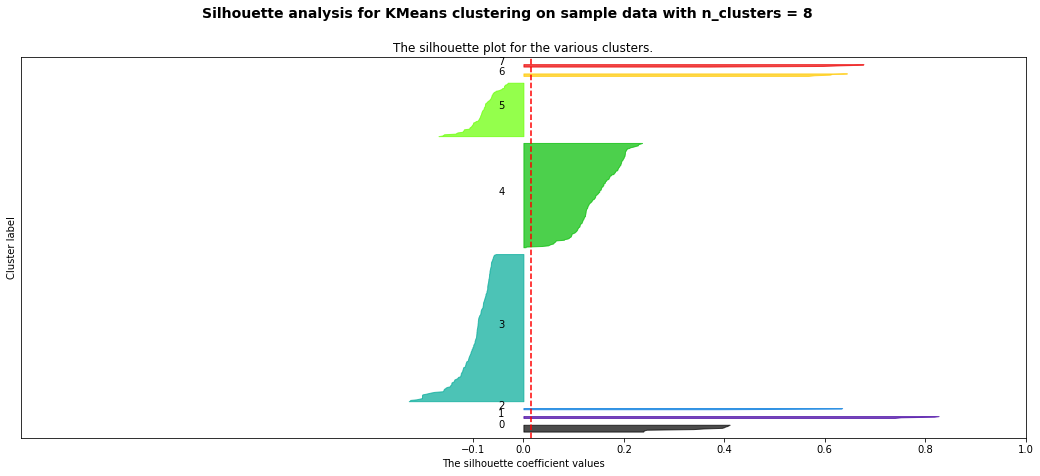

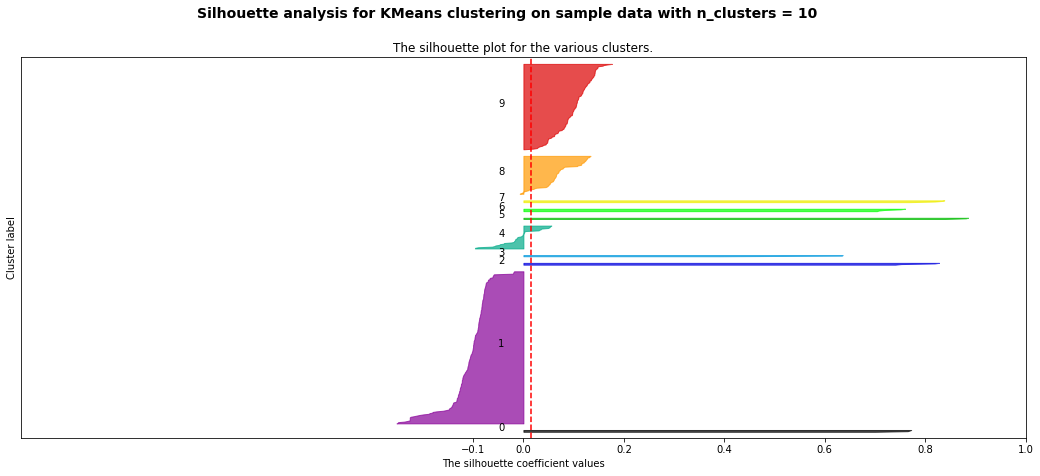

CPU times: user 44.8 s, sys: 704 ms, total: 45.5 s
Wall time: 43.3 s


In [388]:
%%time
X = holdings
n_clusters = [2,3,4,5,6,8,10]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

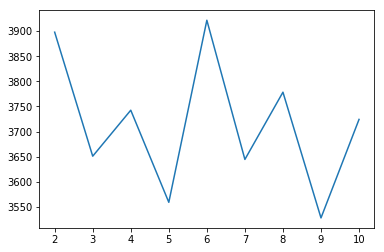

In [54]:
plt.plot(result_mat['Clusters'],result_mat['Inertia'])

In [ ]:
%%time
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

## Visualization only

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ValueError: Input passed into argument "'x2'"is not 1-dimensional.

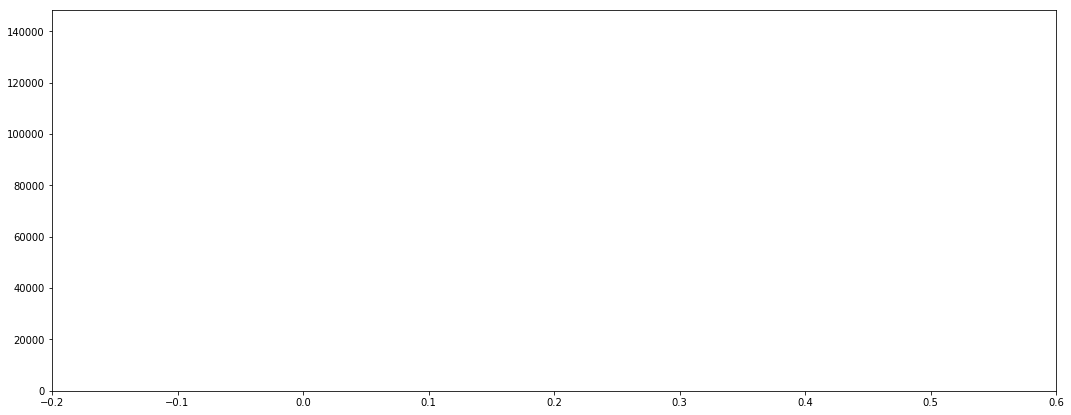

In [48]:
# Inputs
X = holdings
n_clusters = 4
fit_object = kmeans

cluster_labels = fit_object.labels_

sample_silhouette_values = silhouette_samples(X, cluster_labels)

print("Silhouette values calculated")

fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.2, 0.6])
ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

y_lower = 10
i = 0

for obj_code in obj_codes:

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == obj_code]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
        i =+ 1
        print("First Done: ",obj_code)

plt.show()